In [1]:
from ml_review_assistant import Assistant
from gensim.models.nmf import Nmf
import pandas as pd
import tempfile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

assistant = Assistant()

In [2]:
def generate_dataset():
    input_pdf_path = '...' # place the path here
    output_path = '...' # place the path here
    assistant.dataset(input_pdf_path, output_path)

def plot_top_terms(tops):
    data = pd.DataFrame(tops, columns=['term', 'frequency'])
    fig = plt.figure(figsize=(20,7))
    g = sns.barplot(
        x='term',
        y='frequency',
        data=data,
        palette='GnBu_d'
    )
    g.set_xticklabels(
        g.get_xticklabels(),
        rotation=45,
        fontsize=14
    )
    plt.yticks(fontsize=14)
    plt.xlabel('Terms', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Top terms', fontsize=17)

    fig.savefig(
        'data/top_terms.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )
    plt.show()

def plot_coherence_scores(explorer):
    scores = explorer.scores()
    max_score = max(map(lambda v: v[1], explorer.scores()))
    max_topics = max(map(lambda v: v[0], explorer.scores()))
    data = pd.DataFrame(scores, columns=['topics', 'score'])
    fig = plt.figure(figsize=(15, 7))

    g = sns.lineplot(
        x='topics',
        y='score',
        data=data,
        linewidth=3,
        palette='GnBu_d'
    )

    plt.yticks(fontsize=14)
    plt.xticks(np.arange(5, max_topics + 1, 5), fontsize=12)
    plt.xlabel("Topic number", fontsize=14)
    plt.ylabel("Coherence score", fontsize=14)
    plt.title('Coherence score', fontsize=17)
    plt.axvline(explorer.best(), 0, 1, color='g', label='Best topics number: {}'.format(explorer.best()))

    fig.savefig(
        'data/coherence_score.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )
    plt.legend()
    plt.show()
    
def model_builder(num_topics, corpus, dictionary):
    return Nmf(
        corpus=corpus, 
        id2word=dictionary, 
        num_topics=num_topics, 
        random_state=42, 
        kappa=0.1
    )

def read_dataset():
    # Read already cleaned dataset by assistent
    data = pd.read_csv('data/dataset.csv', names=['paper', 'content'], dtype='object', header=0)
    data.content = data.content.str.split()
    return data

def experiment_topic_numbers(data, range_topics):
    # Instantiate Assistant's Explorer
    explorer = assistant.explorer(data.content)

    # Calculate coherence for diferent number of extracted topics by same model
    for num_topics in range_topics:
        explorer.coherence(num_topics, model_builder)
    return explorer

def resume_best_model(explorer, model_builder):
    resume = pd.DataFrame(
        explorer.resume(
            explorer.best(), 
            model_builder
        ), 
        columns=['topic_id', 'topic_score', 'topic_keywords', 'document_original_id']
    )
    grouped = resume.groupby(['topic_id', 'topic_keywords']).count()[['document_original_id']]
    grouped.columns = ['papers']
    return grouped

In [3]:
data = read_dataset()
explorer = experiment_topic_numbers(data, range(1, 20))
resume = resume_best_model(explorer, model_builder)

## Termos mais frequentes no dataset

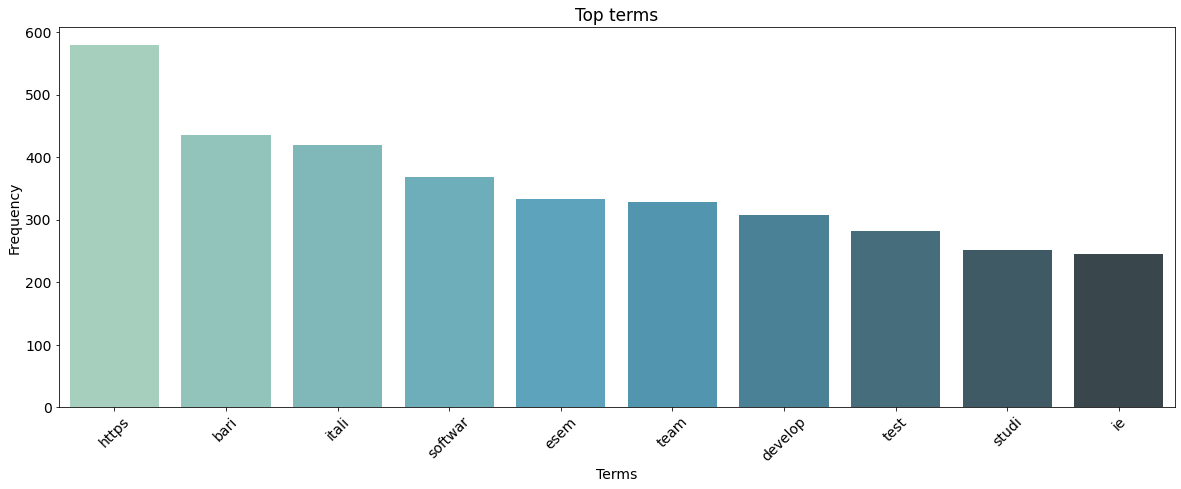

In [4]:
plot_top_terms(explorer.top(10))

## Análise de coerência do modelo pelo número de tópicos extraídos

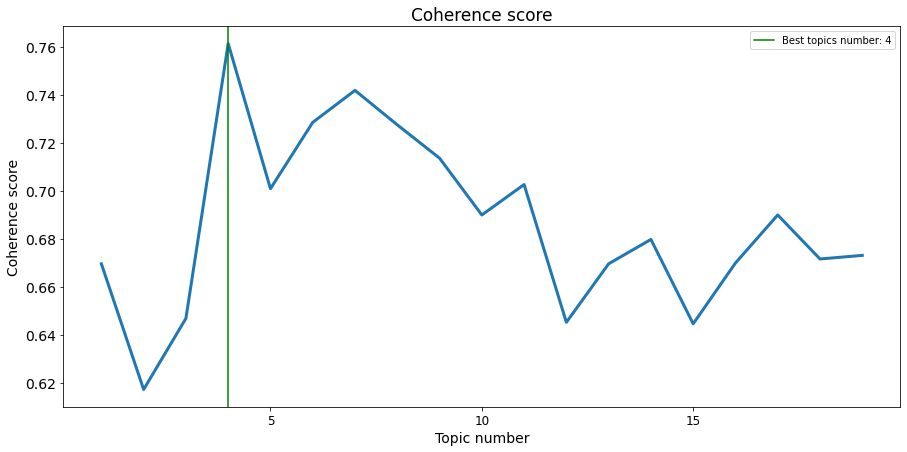

In [5]:
plot_coherence_scores(explorer)